In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

all_cards = pd.read_csv('data/card_data.csv')

# 属性あり <=> モンスター
monsters = all_cards[pd.notnull(all_cards['Attribute'])]
all_cards.head(5)

,Name,Type,Level,Race,Attribute,ATK,DEF
0,Limit Reverse,Trap Card,NaN,Continuous,NaN,NaN,NaN
1,The 13th Grave,Normal Monster,3.0,Zombie,DARK,1200.0,900.0
2,Gem-Enhancement,Trap Card,NaN,Normal,NaN,NaN,NaN
3,Magician's Circle,Trap Card,NaN,Normal,NaN,NaN,NaN
4,Castle of Dark Illusions,Flip Effect Monster,4.0,Fiend,DARK,920.0,1930.0


In [76]:
x = monsters.drop(columns='Attribute')
t = monsters[['Attribute']]

import sklearn.preprocessing as sp

le = sp.LabelEncoder()

def transform_to_int(df, column_name):
    le.fit(df[column_name])
    df.loc[:, column_name] = le.transform(df[column_name])

# chainerはデフォルトでは文字を受け付けないので数値に変換。
transform_to_int(x, "Type")
transform_to_int(x, "Race")
transform_to_int(t, "Attribute")

# この変換は不適切。単に多重度に応じて数字を割り当てているだけ。
transform_to_int(x, "Name")

x = x.astype('float32')
x = x.to_numpy()

t = t.astype('int32')
t = t.to_numpy()
# 行列からベクトルへ次元を下げる
t = t.flatten()


In [64]:
import chainer
# chainer.print_runtime_info()

# データセットを分割するモジュールの読み込み
from sklearn.model_selection import train_test_split
x_train_val, x_test, t_train_val, t_test = train_test_split(x, t, test_size=0.3, random_state=0)

x_train, x_val, t_train, t_val = train_test_split(x_train_val, t_train_val, test_size=0.3, random_state=0)


import chainer.links as L
import chainer.functions as F

# 入力次元数が 6、出力次元数が 7 の全結合層
l = L.Linear(6, 7)

from chainer import Sequential

# net としてインスタンス化
n_input = 6
n_hidden = 10
n_output = 7

# ReLUって減衰が起きるんじゃなかったっけ
net = Sequential(
    L.Linear(n_input, n_hidden), F.relu,
    L.Linear(n_hidden, n_hidden), F.relu,
    L.Linear(n_hidden, n_output)
)

optimizer = chainer.optimizers.SGD(lr=0.01)

optimizer.setup(net)

# 数値コピペ
n_epoch = 30
n_batchsize = 16

import numpy as np

iteration = 0

# ログの保存用
results_train = {
    'loss': [],
    'accuracy': []
}
results_valid = {
    'loss': [],
    'accuracy': []
}


for epoch in range(n_epoch):

    # データセット並べ替えた順番を取得
    order = np.random.permutation(range(len(x_train)))
    
    # 各バッチ毎の目的関数の出力と分類精度の保存用
    loss_list = []
    accuracy_list = []

    for i in range(0, len(order), n_batchsize):
        # バッチを準備
        index = order[i:i+n_batchsize]
        x_train_batch = x_train[index,:]
        t_train_batch = t_train[index]

        # 予測値を出力
        y_train_batch = net(x_train_batch)

        # 目的関数を適用し、分類精度を計算

        loss_train_batch = F.softmax_cross_entropy(y_train_batch, t_train_batch)
        accuracy_train_batch = F.accuracy(y_train_batch, t_train_batch)

        loss_list.append(loss_train_batch.array)
        accuracy_list.append(accuracy_train_batch.array)

        # 勾配のリセットと勾配の計算
        net.cleargrads()
        loss_train_batch.backward()

        # パラメータの更新
        optimizer.update()

        # カウントアップ
        iteration += 1

    # 訓練データに対する目的関数の出力と分類精度を集計
    loss_train = np.mean(loss_list)
    accuracy_train = np.mean(accuracy_list)

    # 1エポック終えたら、検証データで評価
    # 検証データで予測値を出力
    with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
        y_val = net(x_val)

    # 目的関数を適用し、分類精度を計算
    loss_val = F.softmax_cross_entropy(y_val, t_val)
    accuracy_val = F.accuracy(y_val, t_val)

    # 結果の表示
    print('epoch: {}, iteration: {}, loss (train): {:.4f}, loss (valid): {:.4f}'.format(
        epoch, iteration, loss_train, loss_val.array))

    # ログを保存
    results_train['loss'] .append(loss_train)
    results_train['accuracy'] .append(accuracy_train)
    results_valid['loss'].append(loss_val.array)
    results_valid['accuracy'].append(accuracy_val.array)

epoch: 0, iteration: 131, loss (train): 15874.6104, loss (valid): 1.8383
epoch: 1, iteration: 262, loss (train): 1.8105, loss (valid): 1.7880
epoch: 2, iteration: 393, loss (train): 1.7719, loss (valid): 1.7590
epoch: 3, iteration: 524, loss (train): 1.7486, loss (valid): 1.7408
epoch: 4, iteration: 655, loss (train): 1.7337, loss (valid): 1.7289
epoch: 5, iteration: 786, loss (train): 1.7238, loss (valid): 1.7213
epoch: 6, iteration: 917, loss (train): 1.7172, loss (valid): 1.7160
epoch: 7, iteration: 1048, loss (train): 1.7126, loss (valid): 1.7127
epoch: 8, iteration: 1179, loss (train): 1.7095, loss (valid): 1.7103
epoch: 9, iteration: 1310, loss (train): 1.7071, loss (valid): 1.7086
epoch: 10, iteration: 1441, loss (train): 1.7054, loss (valid): 1.7075
epoch: 11, iteration: 1572, loss (train): 1.7042, loss (valid): 1.7068
epoch: 12, iteration: 1703, loss (train): 1.7032, loss (valid): 1.7060
epoch: 13, iteration: 1834, loss (train): 1.7021, loss (valid): 1.7053
epoch: 14, iteratio

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt

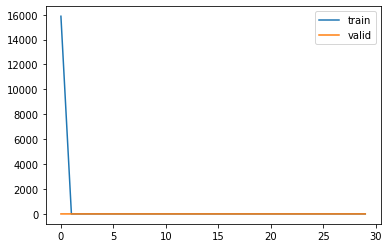

In [66]:
# 目的関数の出力 (loss)
plt.plot(results_train['loss'], label='train')  # label で凡例の設定
plt.plot(results_valid['loss'], label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示

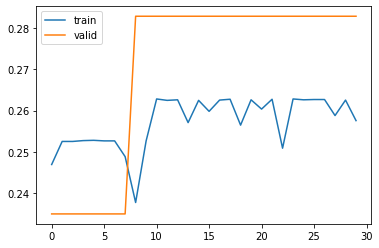

In [67]:
# 分類精度 (accuracy)
plt.plot(results_train['accuracy'], label='train')  # label で凡例の設定
plt.plot(results_valid['accuracy'], label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示

In [68]:
# テストデータで予測値を計算
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y_test = net(x_test)

In [69]:
accuracy_test = F.accuracy(y_test, t_test)
accuracy_test.array

array(0.24395947, dtype=float32)

In [70]:
chainer.serializers.save_npz('my_yugioh.net', net)
!ls

README.md  data  my_yugioh.net	requirements.txt  yu-gi-oh.ipynb  yugienv


In [71]:
loaded_net = Sequential(
    L.Linear(n_input, n_hidden), F.relu,
    L.Linear(n_hidden, n_hidden), F.relu,
    L.Linear(n_hidden, n_output)
)

In [72]:
chainer.serializers.load_npz('my_yugioh.net', loaded_net)

In [73]:
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y_test = loaded_net(x_test)

In [74]:
np.argmax(y_test[0,:].array)

0